In [2]:
import os
import io
import json
import keras
import numpy             as np
import pandas            as pd
import tensorflow        as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from PIL         import Image
from tqdm        import tqdm
from scipy.stats import norm
from tabulate    import tabulate
from keras       import layers,models

## Define the problem and the Labels

We will create a continuum flux at $1$, with some Gaussian absorbers in it.
<br>
All the "pixels" belonging to the continuum are labeled as $0$.
<br>
All the "pixels" belonging to the absorbers are labeled as $1$.

Text(0.5, 1.0, 'Labelling criteria example')

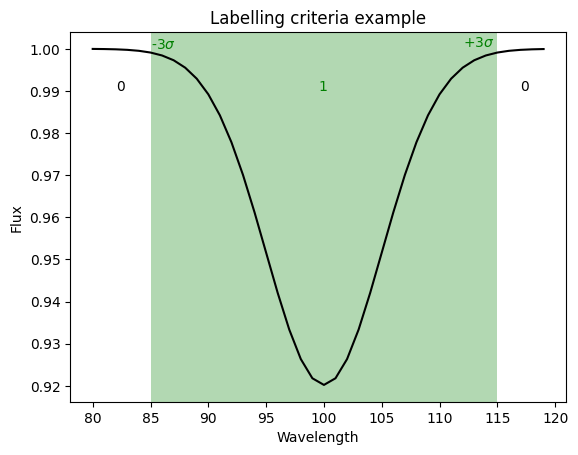

In [4]:
center = 100
sigma = 5

x = np.arange(center - 4 * sigma, center + 4 * sigma, 1)
gaussian = norm.pdf(x, center, sigma)

# Plot
plt.plot(x, 1-gaussian, color='black')

plt.text(center - 3 * sigma, 1-norm.pdf(center - 3 * sigma, center, sigma)+0.001, r'-3$\sigma$', color='green')
plt.text(center + 3 * sigma -3, 1-norm.pdf(center + 3 * sigma -3, center, sigma)+0.005, r'+3$\sigma$', color='green')

plt.axvspan(center - 3 * sigma, center + 3 * sigma, facecolor='green', alpha=0.3)

plt.text(82, 0.99, r'$0$', color='black')
plt.text(117, 0.99, r'$0$', color='black')

plt.text(99.5, 0.99, r'$1$', color='green')

plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title('Labelling criteria example')

## Single example

First, we see how to add a single Gaussian aborber to the continuum.
<br>
Create a wavelength array from $0$ to $999$, with spacing $= 1$. We assume the wavelength can then be mapped exactly on this array.

Create a flux at $1$. We want to add gaussian absorption lines. We use scipy.stats.norm.
<br>
The probability density function for **norm.pdf(x, loc, scale)** is
$$
f(x) = \frac{1}{scale \sqrt{2\pi}} \cdot exp\left[{-\frac{1}{2}\left(\frac{(x - loc)}{scale}\right)^2}\right]
$$
<br>
with **loc = mean**  and **scale = standard deviation**.
<br>
Their position and standar deviation are sampled uniformly at random.

In [15]:
wavelength = np.arange(0,1000,1)
flux = np.zeros(len(wavelength)) + 1.0

# Number of gaussian absorber to insert
# For this example we only insert two
number = 2

# Randomly sample std and initialize the position array
sigma    = np.random.uniform(0.5,5,number)
position = np.zeros(number)

# Create a segmentation mask for each 'pixel' of the wavelength array
# 0 = nothing    1 = absorber
segmentation_mask = np.zeros(len(wavelength))

temp = 0
while temp<number:

    # For sampling the positions, stay 3 sigma from the edges at least
    position_temp = np.random.randint(min(wavelength)+3*sigma[temp],max(wavelength)-3*sigma[temp])
    strength_temp = np.random.uniform(1,250)

    # Proceed only if the new position is not overlapping another absorber
    if all( element==0 for element in segmentation_mask[int(position_temp-3*sigma[temp]):int(position_temp+3*sigma[temp])]):

        # Save the new position center
        position[temp] = position_temp

        # Create the gaussian absorber as an optical depth array, then apply it to the flux
        tau = strength_temp*norm.pdf(wavelength, position_temp, sigma[temp])
        flux *= np.exp(-tau)

        # Clip the flux to make a line saturated if it goes below 0
        #flux = np.clip(flux, 0, None)

        # Update segmentation mask
        segmentation_mask[int(position_temp-3*sigma[temp]):int(position_temp+3*sigma[temp])] = 1

        print('Generated Gaussian absorber at {:3.2f} pix, with sigma {:3.2f} pix and amplitude {:3.2f}'.format(position[temp], sigma[temp], strength_temp))

        temp += 1

Generated Gaussian absorber at 444.00 pix, with sigma 4.09 pix and amplitude 193.90
Generated Gaussian absorber at 53.00 pix, with sigma 1.59 pix and amplitude 195.14


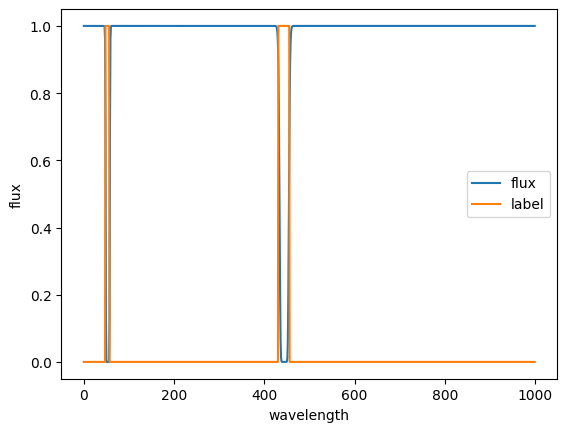

In [16]:
# Plot
plt.plot(wavelength,flux, label='flux')
plt.plot(wavelength, segmentation_mask, label='label')
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.legend()

# The dataset

To built the dataset, we create N_sample spectra with different absorbers in it.

In [ ]:
N_sample = 15000

## Create spectra

Now, we also add random **gaussian noise** to the continuum.
<br>
Furthermore, we also randomly sample the **amplitude** of the absorbers.

In [ ]:
def create_spectrum(num_abs, snr):

    # Create a wavelength array
    wavelength = np.arange(0,1000,1)

    # Create a flux, at 1
    cont = snr**2
    flux = np.ones(len(wavelength)) * cont

    # Number of gaussian absorber to insert
    number = num_abs

    # Randomly sample amplitude, std and initialize position array
    A        = np.random.uniform(1,250,number)
    sigma    = np.random.uniform(0.5,5,number)
    position = np.zeros(number)

    # Create a segmentation mask
    # 0 = nothing    1 = absorber
    segmentation_mask = np.zeros(len(wavelength))

    temp = 0
    while temp<number:

        # For sampling the positions, stay 3 sigma from the edges at least
        position_temp = np.random.randint(min(wavelength)+3*sigma[temp],max(wavelength)-3*sigma[temp])

        # Proceed only if the new position is not overlapping another absorber
        if all( element==0 for element in segmentation_mask[int(position_temp-3*sigma[temp]):int(position_temp+3*sigma[temp])]):

            # Save the new position center
            position[temp] = position_temp

            # Create the gaussian absorber within 3 sigma from the center
            x        = np.arange(int(position_temp - 3 * sigma[temp]), int(position_temp + 3 * sigma[temp]), 1)

            # Here we multiply for the amplitude
            tau = A[temp] * norm.pdf(wavelength, position_temp, sigma[temp])

            # Update the flux array subtracting the gaussian absorber from the continuum
            flux *= np.exp(-tau)

            # Clip the flux to make a line saturated if it goes below 0
            #flux = np.clip(flux, 0, None)

            # Update segmentation mask
            segmentation_mask[int(position_temp-3*sigma[temp]):int(position_temp+3*sigma[temp])] = 1

            temp += 1

    noisy = 1.*np.random.poisson(flux)

    noisy /= cont

    return noisy, segmentation_mask

In [ ]:
# Randomly decide the number of absorbers for each sample
num_abs = np.random.randint(3,30, N_sample)
snr = 5

image   = []
mask    = []

# We loop over and create N_sample spectra
for i in tqdm(range(N_sample)):

    # Create the spectrum
    image_, mask_ = create_spectrum(num_abs[i], snr = snr)

    # Save the spectrum and the labels
    image.append(image_[:,np.newaxis])
    mask.append(np.array(mask_[:,np.newaxis]))

100%|██████████| 15000/15000 [00:39<00:00, 377.54it/s]


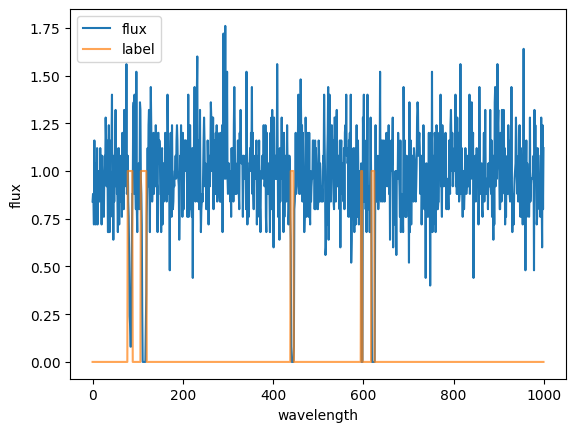

In [ ]:
# Plot an example spectrum
ind = np.random.choice(len(image))
plt.plot(wavelength, image[ind], label='flux')
plt.plot(wavelength, mask[ind], label='label', alpha = 0.7)
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.legend()

In [ ]:
# Create the dataset for Unets

# as above, set the random seed to randomly split the images in a repeatable way. Try different values!
random_state = 42

X = np.asarray(image).astype('float32')
Y = np.asarray(mask).astype('float32')

# First split off 30% of the data for validation+testing

# Then divide this subset into training and testing sets


(10500, 1000, 1) (10500, 1000, 1)


# Model

We now build the U-net model.

# Training

$$
J(w) = -\frac{1}{N} ∑_{i=1}^N [y_i log(\hat{y_i}) + (1-y_i) log(1-\hat{y_i})]
$$
<br>
where $y_i$ is the true label and $\hat{y_i}$ is the predicted label.

In [ ]:
# Use SparseCategoricalCrossentropy when the labels are numbers

# from_logits=True  means that the model predictions are from [-inf, +inf]
# from_logits=False means that the model predictions are from [0,1], so a probability

# The loss function handels itself the conversion from logits to probabilities

model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])


Save the dataset in train and test datasets.

## Confusion matrix

To understand the recovery of the absorption lines, we can compute a confusion matrix with the true and predicted labels.

We can try to use this weighted loss to upweight the 1 labels

In [ ]:
import tensorflow as tf
from tensorflow import keras

class WeightedSCCE(keras.losses.Loss):
        def __init__(self, class_weight, from_logits=False, name='weighted_scce'):
            if class_weight is None or all(v == 1. for v in class_weight):
                self.class_weight = None
            else:
                self.class_weight = tf.convert_to_tensor(class_weight,dtype=tf.int32)
            self.name = name
            self.reduction = keras.losses.Reduction.NONE
            self.unreduced_scce = keras.losses.SparseCategoricalCrossentropy(
                from_logits=from_logits, name=name,
                reduction=self.reduction)

        def __call__(self, y_true, y_pred, sample_weight=None):
            loss = self.unreduced_scce(y_true, y_pred, sample_weight)
            if self.class_weight is not None:
                weight_mask = tf.cast(tf.gather(self.class_weight, y_true), dtype=tf.float32)
                loss = tf.math.multiply(loss, weight_mask)
            return loss

In [ ]:
model.compile(optimizer='adam',loss=WeightedSCCE([1,50],from_logits=True),metrics=["accuracy"])